In [44]:
reset -fs

In [45]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 25 by 25.

In [46]:
with gzip.open('pre_processed_images/image_data_20000_25.txt.gz', 'rb') as f:
  X, y = pickle.load(f)

#### Since we are not using a GPU, we will get a random sample from the OK and NOK images. We know the OK images are the first 10,000, the NOK ones the last 10,000.

#### We get all OK images.

In [47]:
X_ok = X[:10000]

#### We get all NOK images.

In [48]:
X_nok = X[10000:]

In [75]:
ARRAY_SAMPLE = 1000

#### We get a random sample of the OK images.

In [76]:
X_ok_sample = X_ok[np.random.randint(0, X_ok.shape[0], ARRAY_SAMPLE)]

#### We get a random sample of the NOK images.

In [77]:
X_nok_sample = X_nok[np.random.randint(0, X_nok.shape[0], ARRAY_SAMPLE)]

#### Creating final array of images ready to fit a model.

Note that we stack first the 'good' images, then the 'bad' ones.

In [78]:
X_sample = np.vstack((X_ok_sample, X_nok_sample))

#### Creating an array of labels.
Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [79]:
y_sample = np.vstack((np.array([1]*(len(X_sample)/2)).reshape((len(X_sample)/2), 1), np.array([0]*(len(X_sample)/2)).reshape((len(X_sample)/2), 1)))

#### Creating a train, test split.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [81]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [82]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

##### The image size is 25.

In [83]:
IMG_SIZE = 25

In [84]:
model_1 = dl_functions.cnn_model_v_0(IMG_SIZE)

In [85]:
model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [86]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 25, 25, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)          0         
__________

In [87]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=40, verbose=1, validation_split=0.3)

Train on 979 samples, validate on 421 samples
Epoch 1/40
979/979 [==============================] - 13s - loss: 0.7039 - acc: 0.5455 - val_loss: 0.6847 - val_acc: 0.4964
Epoch 2/40
979/979 [==============================] - 12s - loss: 0.6890 - acc: 0.5822 - val_loss: 0.7196 - val_acc: 0.4679
Epoch 3/40
979/979 [==============================] - 12s - loss: 0.6483 - acc: 0.6108 - val_loss: 0.6360 - val_acc: 0.6485
Epoch 4/40
979/979 [==============================] - 12s - loss: 0.6391 - acc: 0.6231 - val_loss: 0.6110 - val_acc: 0.6722
Epoch 5/40
979/979 [==============================] - 12s - loss: 0.5965 - acc: 0.6558 - val_loss: 0.6079 - val_acc: 0.6508
Epoch 6/40
979/979 [==============================] - 12s - loss: 0.7175 - acc: 0.6292 - val_loss: 0.5999 - val_acc: 0.6888
Epoch 7/40
979/979 [==============================] - 12s - loss: 0.5801 - acc: 0.6803 - val_loss: 0.5758 - val_acc: 0.6960
Epoch 8/40
979/979 [==============================] - 12s - loss: 0.5870 - acc: 0.6793

In [88]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

576/600 [===========================>..] - ETA: 0s

In [89]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 0.5309
Test accuracy: 75.33%


#### Creating a list of predictions.

In [90]:
predicted_images = []
for i in model_1.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

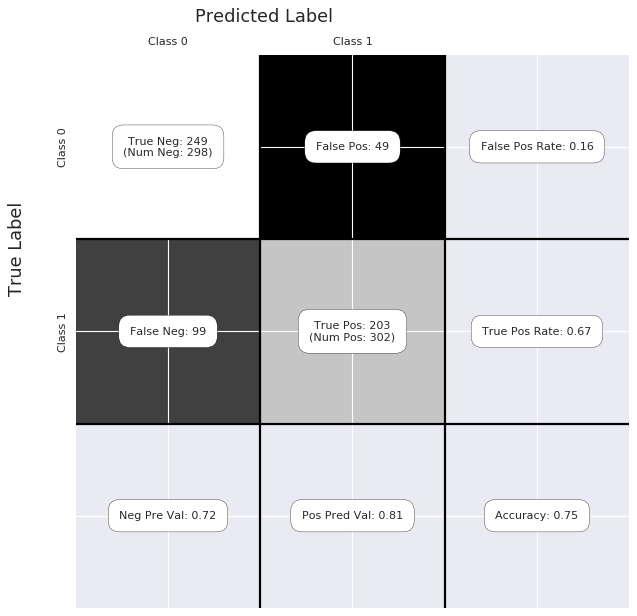

In [91]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [92]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,249,49
1,99,203


In [93]:
predictions_probability = model_1.predict_proba(X_test)

576/600 [===========================>..] - ETA: 0s

#### Plotting a ROC curve.

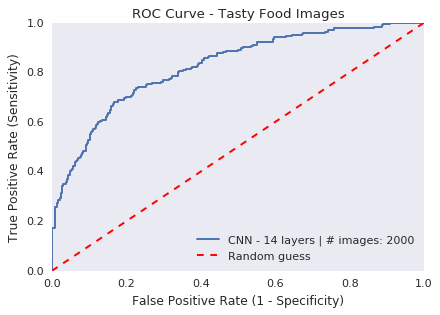

In [94]:
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X_sample)), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [95]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [96]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [97]:
trump_prediction[0]

0

In [98]:
trump.shape

(1, 25, 25, 3)

In [99]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as bad.

In [100]:
img = array_to_img(trump)
display(img)